<a href="https://colab.research.google.com/github/UdayMekaa/Google-Playstore-App-ratings-Prediction/blob/main/Google_Playstore_app_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Summary – Predicting Google Play Store App Ratings Using Reviews & Metadata
---
This dataset consists of web scraped data of more than 10,000 Google Play Store apps and 60,000 app reviews. apps_data.csv consists of data about the apps such as category,

####Dataset:

* Apps data: 10,841 records, 13 features (Category, Size, Installs, Price, Content Rating, etc.)
* Reviews data: 64,295 records, 5 features (Translated Review, Sentiment, Polarity, Subjectivity, etc.)

####Scenario:
* Analyze Factors that Increase the Rating an App Will Receive
* This scenario helps you develop an end-to-end project for your portfolio.

####Background:
You are working for an app developer. They are in the process of brainstorming a new app. They want to ensure that their next app scores a high review on the app store, as this can lead to the app being featured on the store homepage.

#### Objective:
They would like you analyze what factors increase the rating an app will receive. They would also like to know what impact reviews have on the final score.

You will need to prepare a report that is accessible to a broad audience. It should outline your motivation, steps, findings, and conclusions.



>## Load and pre-view Datasets
>* Loads the CSVs into DataFrames.
* Shows shapes (rows × columns).
* Lists column names so we can verify they match the expected ones.
* Prints the first 5 rows of each dataset for a sanity check.



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub
import joblib
import os


In [ ]:
# Download latest version
path = kagglehub.dataset_download("lava18/google-play-store-apps")

print("Path to dataset files:", path)

100%|██████████| 1.94M/1.94M [00:00<00:00, 2.39MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lava18/google-play-store-apps/versions/6


In [ ]:
# The path to the dataset files is available from the output of the first cell
dataset_path = "/root/.cache/kagglehub/datasets/lava18/google-play-store-apps/versions/6"

# List all files in the dataset directory
files = os.listdir(dataset_path)
print("Files in the dataset directory:", files)

# Assuming the primary data file is a CSV, let's read it
# You might need to adjust the filename based on the actual files present
csv_file_name = "googleplaystore.csv"
csv_file_path = os.path.join(dataset_path, csv_file_name)

if os.path.exists(csv_file_path):
    apps_df = pd.read_csv(csv_file_path)
    display(df.head())
else:
    print(f"CSV file '{csv_file_name}' not found in the dataset directory.")

In [ ]:
user_reviews_csv_file_name = "googleplaystore_user_reviews.csv"
user_reviews_csv_file_path = os.path.join(dataset_path, user_reviews_csv_file_name)

if os.path.exists(user_reviews_csv_file_path):
    reviews_df = pd.read_csv(user_reviews_csv_file_path)
    display(reviews_df.head())
else:
    print(f"CSV file '{user_reviews_csv_file_name}' not found in the dataset directory.")

In [ ]:
print("app shape =",apps_df.shape)
print("reviews shape =",reviews_df.shape)

app shape = (10841, 13)
reviews shape = (64295, 5)


In [ ]:
print("\nApps data columns:", apps_df.columns.tolist())
print("\nReviews data columns:", reviews_df.columns.tolist())


Apps data columns: ['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']

Reviews data columns: ['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity', 'Sentiment_Subjectivity']


In [ ]:
# Peek at the first few rows
print("\nApps data sample:", apps_df.head())
print("\nReviews data sample:",reviews_df.head())


Apps data sample:                                                  App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Ar

>## Data Cleaning
>What this will fix:
>
>* Reviews and Rating → numbers.
* Size like **14M, 600k** → MB.
* Installs like **1,000+** → integer.
* Price like **$0.99** → float.
* Sentiment scores → numeric.


In [ ]:
# Make a copy to avoid touching original
apps_clean = apps_df.copy()
reviews_clean = reviews_df.copy()

In [ ]:
# Convert numeric columns
apps_clean["Reviews"] = pd.to_numeric(apps_clean["Reviews"], errors="coerce")
apps_clean["Rating"] = pd.to_numeric(apps_clean["Rating"], errors="coerce")

In [ ]:
# Clean 'Size' → convert to MB
def size_to_mb(size):
    if pd.isna(size) or "Varies" in size:
        return np.nan
    size = size.strip()
    try:
        if size.endswith("M"):
            return float(size[:-1])
        elif size.endswith("k"):
            return float(size[:-1]) / 1024
    except:
        return np.nan
    return np.nan

apps_clean["Size_MB"] = apps_clean["Size"].apply(size_to_mb)

In [ ]:
# Clean 'Installs' → integer
apps_clean = apps_clean[apps_clean['Installs'] != 'Free'].copy() # Filter out the row where 'Installs' is 'Free'
apps_clean["Installs_Num"] = (
    apps_clean["Installs"]
    .str.replace("+", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

In [ ]:
# Clean 'Price' → float
apps_clean["Price_Num"] = (
    apps_clean["Price"]
    .str.replace("$", "", regex=False)
    .astype(float)
)

In [ ]:
reviews_clean["Sentiment_Polarity"] = pd.to_numeric(
    reviews_clean["Sentiment_Polarity"], errors="coerce"
)
reviews_clean["Sentiment_Subjectivity"] = pd.to_numeric(
    reviews_clean["Sentiment_Subjectivity"], errors="coerce"
)

In [ ]:
# Preview cleaned data
print("Apps cleaned sample:")
apps_clean.head()

In [ ]:
print("\nReviews cleaned sample:")
reviews_clean.head()

>## Missing Values Check after Cleaning
>* If a key column like Rating or Sentiment_Polarity has many NaNs, we might need to filter or impute before analysis.
* If App has missing values (unlikely but possible), joining will lose rows.

In [ ]:
# Missing value summary for apps data
print("Missing values in Apps data (top 10):")
print(apps_clean.isna().sum().sort_values(ascending=False).head(10))

print("\nMissing values in Reviews data (top 10):")
print(reviews_clean.isna().sum().sort_values(ascending=False).head(10))


Missing values in Apps data (top 10):
Size_MB        1695
Rating         1474
Current Ver       8
Android Ver       2
Type              1
Reviews           0
Category          0
App               0
Price             0
Installs          0
dtype: int64

Missing values in Reviews data (top 10):
Translated_Review         26868
Sentiment_Polarity        26863
Sentiment                 26863
Sentiment_Subjectivity    26863
App                           0
dtype: int64


>## Aggregate Reviews per App
>We’ll calculate for each app:
>* Number of reviews,
* Share of positive, negative, neutral,
* Mean sentiment polarity & subjectivity.

In [ ]:
# Drop reviews with no sentiment polarity
reviews_valid = reviews_clean.dropna(subset=["Sentiment_Polarity"])

# Aggregate review metrics per app
agg_reviews = reviews_valid.groupby("App").agg(
    Reviews_N=("Translated_Review", "count"),
    Pos_Share=("Sentiment", lambda x: (x == "Positive").mean()),
    Neg_Share=("Sentiment", lambda x: (x == "Negative").mean()),
    Neu_Share=("Sentiment", lambda x: (x == "Neutral").mean()),
    Polarity_Mean=("Sentiment_Polarity", "mean"),
    Subjectivity_Mean=("Sentiment_Subjectivity", "mean")
).reset_index()

print("Aggregated reviews sample:")
print(agg_reviews.head())
print("\nShape:", agg_reviews.shape)


>### Join cleaned apps data with aggregated reviews using a left join
>---
>* Keeps every app from your apps_data.csv.
>* Fills review-related columns with NaN where no review data exists.
>* Useful if you still want to analyze app installs, pricing, or categories even without sentiment info.




In [ ]:
# Join on App (left join keeps all apps)
apps_reviews = apps_clean.merge(
    agg_reviews,
    on="App",
    how="left"
)

print("Joined dataset shape:", apps_reviews.shape)
apps_reviews.head()


Joined dataset shape: (10840, 22)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,...,Android Ver,Size_MB,Installs_Num,Price_Num,Reviews_N,Pos_Share,Neg_Share,Neu_Share,Polarity_Mean,Subjectivity_Mean
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,"10,000+",Free,0,Everyone,Art & Design,...,4.0.3 and up,19.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,...,4.0.3 and up,14.0,500000.0,0.0,44.0,0.590909,0.318182,0.090909,0.152652,0.64154
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,...,4.0.3 and up,8.7,5000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25M,"50,000,000+",Free,0,Teen,Art & Design,...,4.2 and up,25.0,50000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,...,4.4 and up,2.8,100000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Quick missing check after join
print("\nMissing values after join (top 10):")
print(apps_reviews.isna().sum().sort_values(ascending=False).head(10))


Missing values after join (top 10):
Pos_Share            9611
Reviews_N            9611
Polarity_Mean        9611
Subjectivity_Mean    9611
Neu_Share            9611
Neg_Share            9611
Size_MB              1695
Rating               1474
Current Ver             8
Android Ver             2
dtype: int64


## Which categories get the highest reviews among the 10 most popular categories?


---
* Define “most popular” by total installs per category.
* Take the top 10 categories.
* Compare their total review counts.
* Visualize with a bar chart.


In [ ]:
# Group by category
cat_stats = apps_reviews.groupby("Category").agg(
    Apps_Count=("App", "count"),
    Total_Installs=("Installs_Num", "sum"),
    Total_Reviews=("Reviews", "sum")
).sort_values("Total_Installs", ascending=False)

# Top 10 categories by installs
top10_cats = cat_stats.head(10)

In [ ]:
print(top10_cats)

                    Apps_Count  Total_Installs  Total_Reviews
Category                                                     
GAME                      1144    3.508602e+10   1.585422e+09
COMMUNICATION              387    3.264728e+10   8.154623e+08
PRODUCTIVITY               424    1.417609e+10   1.141170e+08
SOCIAL                     295    1.406987e+10   6.212414e+08
TOOLS                      843    1.145277e+10   2.731850e+08
FAMILY                    1972    1.025826e+10   4.102263e+08
PHOTOGRAPHY                335    1.008825e+10   2.135166e+08
NEWS_AND_MAGAZINES         283    7.496318e+09   5.440086e+07
TRAVEL_AND_LOCAL           258    6.868887e+09   6.261792e+07
VIDEO_PLAYERS              175    6.222003e+09   1.103802e+08


/tmp/ipython-input-4184327248.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total_Reviews", y=top10_cats.sort_values("Total_Reviews").index, data=top10_cats.sort_values("Total_Reviews"), palette="viridis")


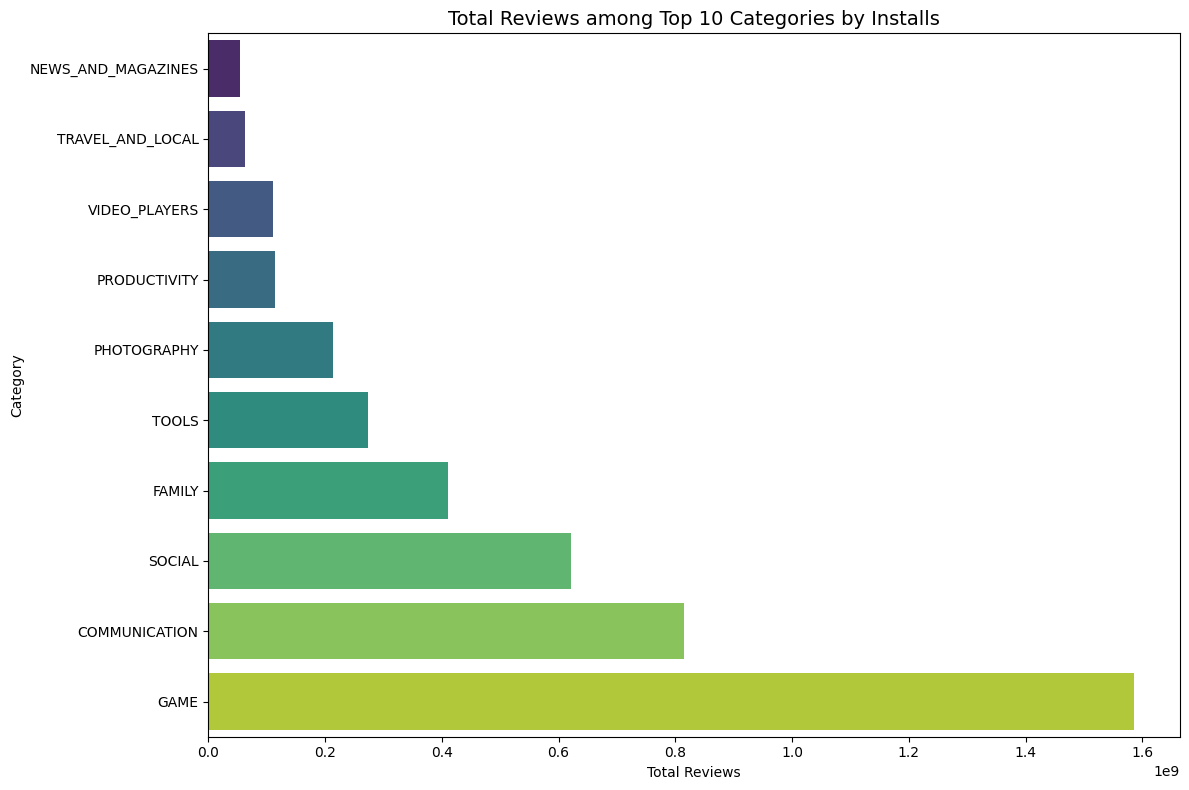

In [ ]:
# Bar chart: Total reviews in top 10 categories
plt.figure(figsize=(12, 8))
sns.barplot(x="Total_Reviews", y=top10_cats.sort_values("Total_Reviews").index,
            data=top10_cats.sort_values("Total_Reviews"), palette="viridis")
plt.xlabel("Total Reviews")
plt.ylabel("Category")
plt.title("Total Reviews among Top 10 Categories by Installs", fontsize=14)
plt.tight_layout()
plt.show()

>## Sentiment Polarity Distribution by Content Rating
>
>---
>
>Does the target audience (content rating) influence the kind of sentiment apps receive in reviews?
>
>* Each box shows how positive or negative the average review sentiment is for that content rating group.
>* The red dashed line marks 0 (neutral sentiment).
>* Outliers above the box suggest some apps get extremely positive sentiment, below the box — more negative.



/tmp/ipython-input-3422821110.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


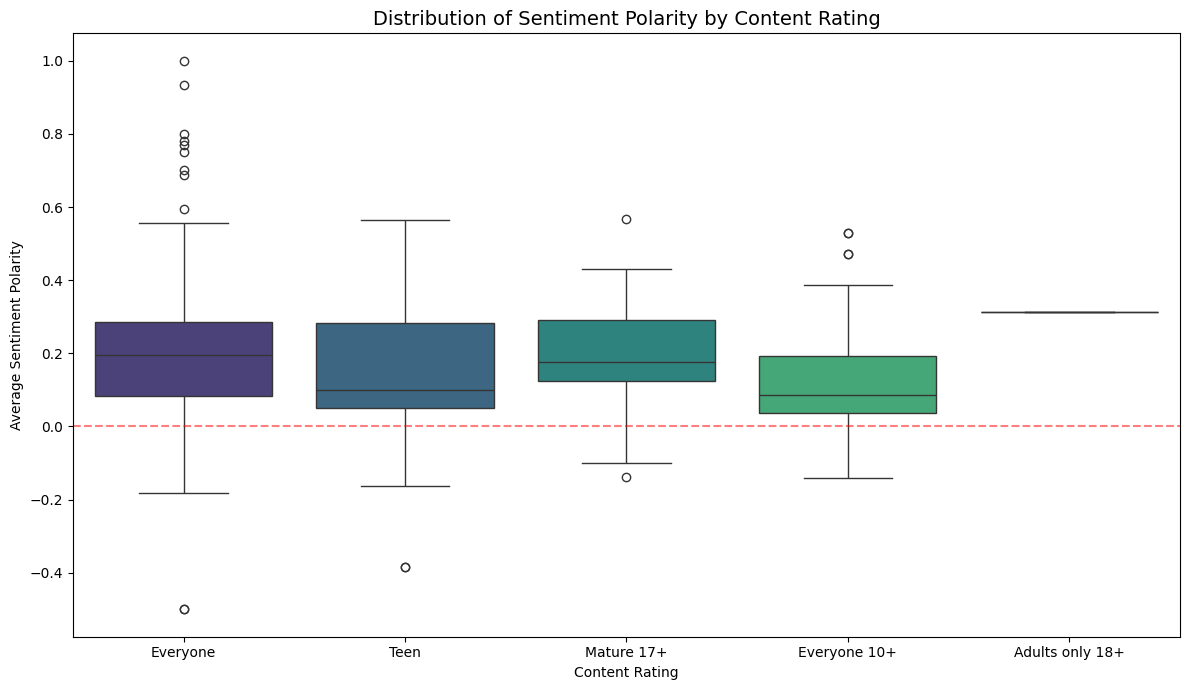

In [ ]:
# Filter rows with polarity and content rating available
sentiment_data = apps_reviews.dropna(subset=["Polarity_Mean", "Content Rating"])

plt.figure(figsize=(12,7))
sns.boxplot(
    data=sentiment_data,
    x="Content Rating",
    y="Polarity_Mean",
    order=sentiment_data["Content Rating"].value_counts().index,
    palette="viridis"
)
plt.axhline(0, color="red", linestyle="--", alpha=0.5)
plt.title("Distribution of Sentiment Polarity by Content Rating", fontsize=14)
plt.ylabel("Average Sentiment Polarity")
plt.xlabel("Content Rating")
plt.tight_layout()
plt.show()

>## Relationship Between Content Rating, Sentiment, and Star Rating
>---
>
>1. Group by Content Rating.
>2. Calculate:
>* Average app star rating
* Average sentiment polarity
* Number of apps in each group
<3. Sort for easy comparison.

In [ ]:
# Group by Content Rating
content_rating_stats = apps_reviews.groupby("Content Rating").agg(
    Avg_Star_Rating=("Rating", "mean"),
    Avg_Sentiment_Polarity=("Polarity_Mean", "mean"),
    Apps_Count=("App", "count")
).sort_values("Avg_Star_Rating", ascending=False)

print(content_rating_stats)

                 Avg_Star_Rating  Avg_Sentiment_Polarity  Apps_Count
Content Rating                                                      
Adults only 18+         4.300000                0.312334           3
Everyone 10+            4.257179                0.138493         414
Teen                    4.233487                0.148216        1208
Everyone                4.186375                0.194811        8714
Mature 17+              4.123427                0.188454         499
Unrated                 4.100000                     NaN           2


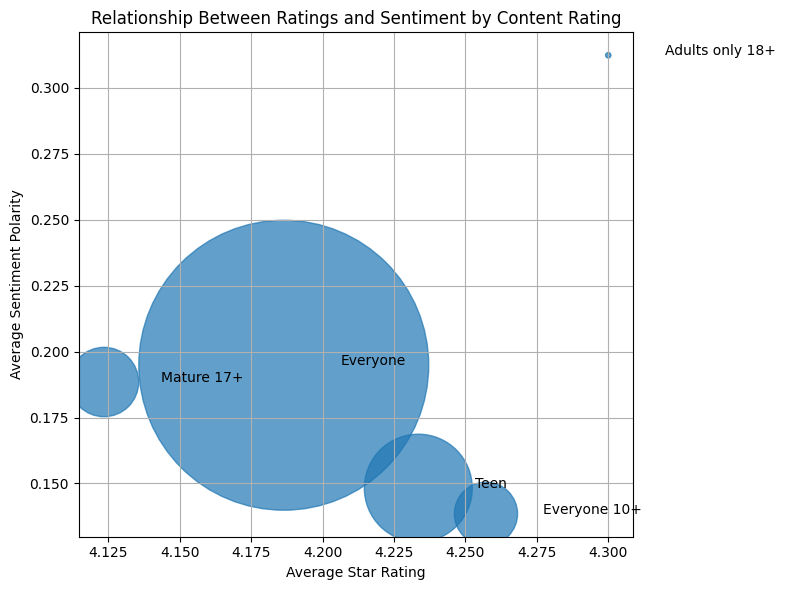

In [ ]:
# Scatter plot: Star rating vs sentiment
plt.figure(figsize=(8,6))
plt.scatter(
    content_rating_stats["Avg_Star_Rating"],
    content_rating_stats["Avg_Sentiment_Polarity"],
    s=content_rating_stats["Apps_Count"]*5,  # bubble size = number of apps
    alpha=0.7
)
for idx, row in content_rating_stats.iterrows():
    plt.text(row["Avg_Star_Rating"]+0.02, row["Avg_Sentiment_Polarity"], idx)

plt.xlabel("Average Star Rating")
plt.ylabel("Average Sentiment Polarity")
plt.title("Relationship Between Ratings and Sentiment by Content Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

>## Identify factors that increase app rating
>
>---
>
>We’ll use a multiple linear regression (or optionally Random Forest) to see which factors matter most.
Before modeling, we need to:
>
>**1. Select relevant features**
>
>* Reviews (log scale — to handle skew)
>* Size_MB
>* Price (numeric)
>* Type (Paid/Free → binary)
>* Installs (numeric, log scale)
>* Content Rating (one-hot encode)
>* Sentiment metrics (Polarity_Mean, Subjectivity_Mean)
>
>**2. Handle missing values**
>
>**3. Scale / transform where needed**

In [ ]:
# Copy dataset
df_model = apps_reviews.copy()

In [ ]:
# Convert Price to numeric
df_model["Price"] = df_model["Price"].replace(r'[\$,]', '', regex=True).astype(float)

In [ ]:
# Convert Installs to numeric
df_model["Installs"] = df_model["Installs"].replace(r'[+,]', '', regex=True).astype(float)

In [ ]:
# Log transform skewed variables
df_model["Reviews_log"] = np.log1p(df_model["Reviews"])
df_model["Installs_log"] = np.log1p(df_model["Installs"])

In [ ]:
# Binary encode Type
df_model["Type_Binary"] = df_model["Type"].map({"Free": 0, "Paid": 1})

In [ ]:
# One-hot encode Content Rating
df_model = pd.get_dummies(df_model, columns=["Content Rating"], drop_first=True)

In [ ]:
# Select features
features = [
    "Reviews_log", "Size_MB", "Price", "Installs_log", "Type_Binary",
    "Polarity_Mean", "Subjectivity_Mean"
] + [col for col in df_model.columns if col.startswith("Content Rating_")]

In [ ]:
# Drop rows with missing in selected features or target
df_model = df_model.dropna(subset=features + ["Rating"])


In [ ]:
# Split data
X = df_model[features]
y = df_model["Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predict & evaluate
y_pred = lr.predict(X_test)
print("R² score:", r2_score(y_test, y_pred))

R² score: 0.2643866646376303


In [ ]:
# Show feature importance
importance = pd.Series(lr.coef_, index=features).sort_values(key=abs, ascending=False)
print("\nFeature Importance (absolute magnitude):")
print(importance)


Feature Importance (absolute magnitude):
Subjectivity_Mean              0.612885
Polarity_Mean                  0.558270
Content Rating_Mature 17+     -0.162545
Reviews_log                    0.099537
Installs_log                  -0.072936
Type_Binary                    0.058306
Content Rating_Everyone       -0.049844
Content Rating_Teen           -0.017137
Price                         -0.009637
Content Rating_Everyone 10+   -0.004562
Size_MB                        0.000087
Content Rating_Unrated         0.000000
dtype: float64


> # Key takeaways
>**1. User sentiment dominates ratings**
>* Subjectivity_Mean (0.61) and Polarity_Mean (0.56) have the strongest impact.
>* In simple terms: if people feel strongly and positively about the app, ratings go up.
>
>**2. Audience type matters**
* Content Rating_Mature 17+ has a negative coefficient (−0.16), suggesting these apps tend to score slightly lower on average (could be niche appeal or controversial content).
>
>**3. Popularity helps — but only a little**
>
>* Reviews_log has a positive impact (0.099) and Installs_log slightly negative (−0.07) — possibly because big apps get more critical reviews.
>
>**4. Paid vs Free**
>
>* Type_Binary is positive (0.058), meaning paid apps tend to get slightly higher ratings, possibly due to higher quality or smaller, more satisfied user bases.
>
>**5. Price barely matters**
>
>* Price has a tiny negative effect (−0.0096). Pricing likely doesn’t directly determine ratings.
>
>* Size of app = irrelevant
>
>* Size_MB is basically zero — the app’s size doesn’t influence ratings.
>
>

> ## Horizontal Bar Charts
>* Green bars → positive effect on ratings
>* Red bars → negative effect on ratings
>* Ordered by absolute importance so the least impactful is at the bottom

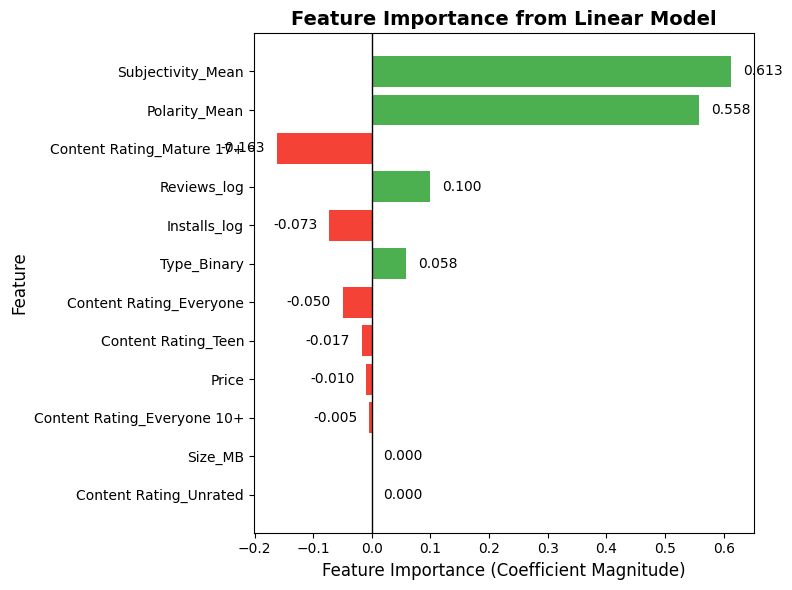

In [ ]:
# Feature importance data
feature_importance = {
    'Subjectivity_Mean': 0.612885,
    'Polarity_Mean': 0.558270,
    'Content Rating_Mature 17+': -0.162545,
    'Reviews_log': 0.099537,
    'Installs_log': -0.072936,
    'Type_Binary': 0.058306,
    'Content Rating_Everyone': -0.049844,
    'Content Rating_Teen': -0.017137,
    'Price': -0.009637,
    'Content Rating_Everyone 10+': -0.004562,
    'Size_MB': 0.000087,
    'Content Rating_Unrated': 0.000000
}

# Convert to DataFrame
df_importance = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])

# Sort by absolute importance
df_importance['Abs_Importance'] = df_importance['Importance'].abs()
df_importance = df_importance.sort_values('Abs_Importance', ascending=True)

# Plot
plt.figure(figsize=(8,6))
colors = ['#4CAF50' if x > 0 else '#F44336' for x in df_importance['Importance']]
bars = plt.barh(df_importance['Feature'], df_importance['Importance'], color=colors)

# Add coefficient annotations
for bar, value in zip(bars, df_importance['Importance']):
    plt.text(
        value + (0.02 if value >= 0 else -0.02),  # offset to right for positive, left for negative
        bar.get_y() + bar.get_height() / 2,
        f"{value:.3f}",
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=10
    )

plt.axvline(0, color='black', linewidth=1)
plt.xlabel('Feature Importance (Coefficient Magnitude)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance from Linear Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

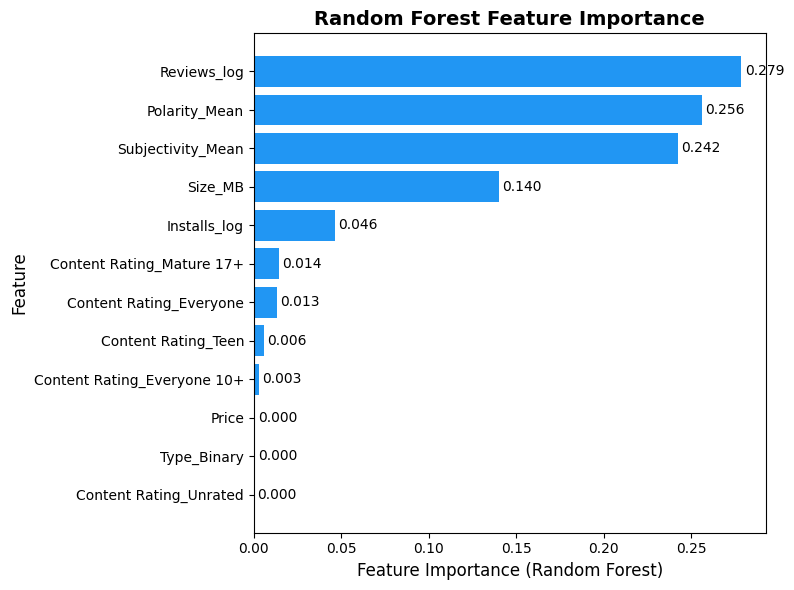

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=True)

# Plot
plt.figure(figsize=(8,6))
bars = plt.barh(rf_importances['Feature'], rf_importances['Importance'], color="#2196F3")

# Add annotations
for bar, value in zip(bars, rf_importances['Importance']):
    plt.text(
        value + 0.002,
        bar.get_y() + bar.get_height() / 2,
        f"{value:.3f}",
        va='center'
    )

plt.xlabel('Feature Importance (Random Forest)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

> ## model performance metrics
>---
>* MAE → average error in predicted ratings
* RMSE → penalizes larger errors more
* R² → how much variance in ratings is explained by the model



In [ ]:
# Predictions
y_pred = rf.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Mean Absolute Error (MAE): 0.167
Root Mean Squared Error (RMSE): 0.238
R² Score: 0.480


In [ ]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Metrics function
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Calculate metrics
lr_metrics = get_metrics(y_test, y_pred_lr)
rf_metrics = get_metrics(y_test, y_pred_rf)

# Compare in a table
import pandas as pd
metrics_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [lr_metrics[0], rf_metrics[0]],
    "RMSE": [lr_metrics[1], rf_metrics[1]],
    "R²": [lr_metrics[2], rf_metrics[2]]
})

metrics_df


,Model,MAE,RMSE,R²
0,Linear Regression,0.210489,0.283103,0.264387
1,Random Forest,0.167463,0.237926,0.480429


>While Linear Regression was able to explain ~26% of the variance in app ratings, Random Forest improved this to ~48%, reducing prediction error by ~20%.

>## Actual vs Predicted comparison for both models
> ---
>* Two scatter plots side by side — each point is an app.
* Red dashed diagonal = perfect prediction line.

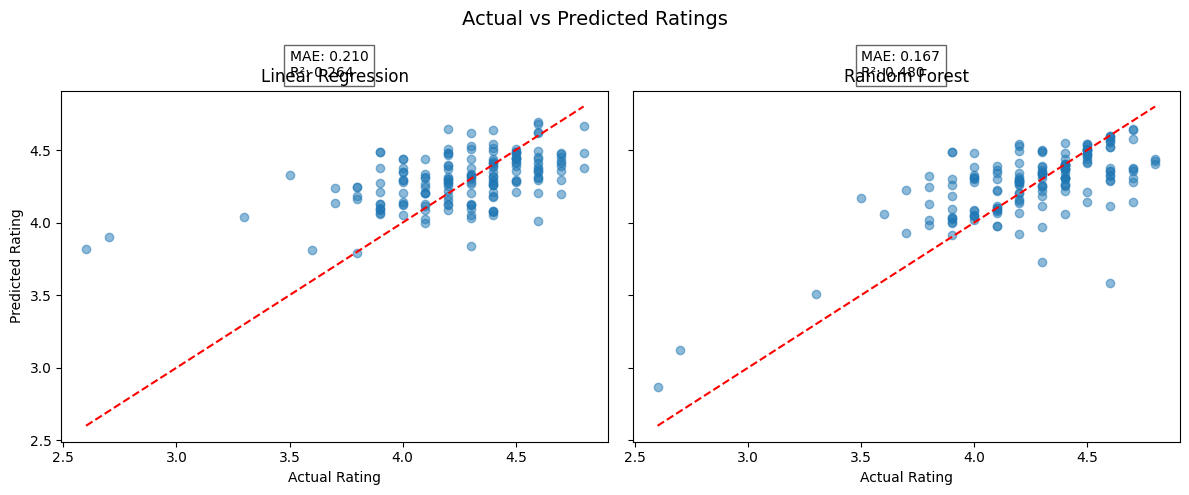

In [ ]:
import matplotlib.pyplot as plt

# Predictions
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Linear Regression plot
axes[0].scatter(y_test, y_pred_lr, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].text(3.5, 5.0, f"MAE: {0.210:.3f}\nR²: {0.264:.3f}", fontsize=10,
             bbox=dict(facecolor='white', alpha=0.6))

# Random Forest plot
axes[1].scatter(y_test, y_pred_rf, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Actual Rating')
axes[1].text(3.5, 5.0, f"MAE: {0.167:.3f}\nR²: {0.480:.3f}", fontsize=10,
             bbox=dict(facecolor='white', alpha=0.6))

plt.suptitle('Actual vs Predicted Ratings', fontsize=14)
plt.tight_layout()
plt.show()


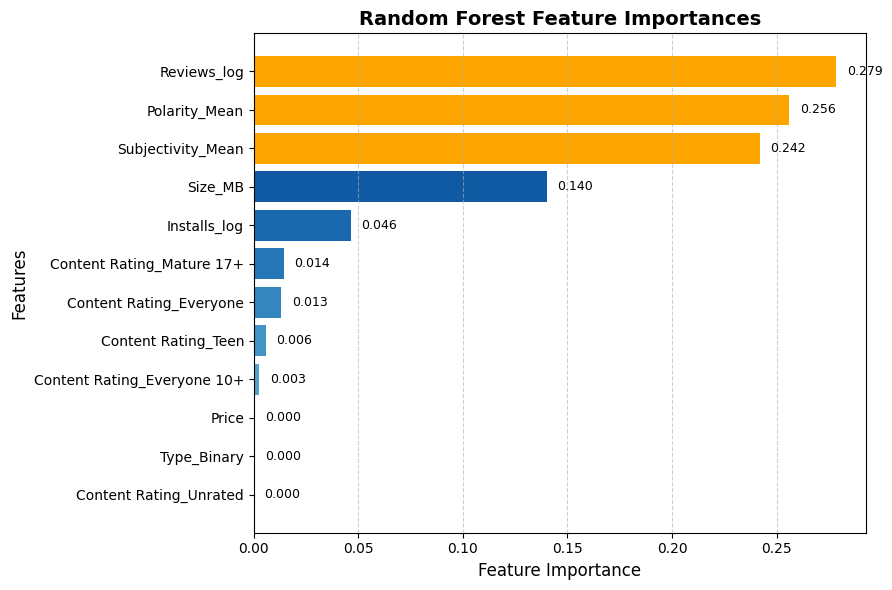

In [ ]:
# Get feature importances from Random Forest
importances = rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame and sort
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Color gradient
colors = plt.cm.Blues(np.linspace(0.4, 1, len(feat_imp_df)))

# Highlight top 3 features in orange
top3_idx = feat_imp_df['Importance'].nlargest(3).index
highlight_colors = [
    'orange' if i in top3_idx else colors[j]
    for j, i in enumerate(feat_imp_df.index)
]

# Plot
plt.figure(figsize=(9, 6))
bars = plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color=highlight_colors)

# Add labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=9)

plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Random Forest Feature Importances', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model
joblib.dump(rf, 'random_forest_rating_model.pkl')

# Later: Load the model
loaded_model = joblib.load('random_forest_rating_model.pkl')

# Example usage
example_pred = loaded_model.predict(X_test[:5])
print("Sample Predictions:", example_pred)


Sample Predictions: [4.1845 4.3765 4.46   4.2915 4.5245]


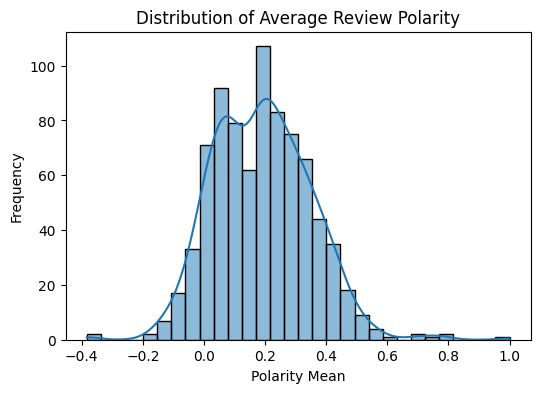

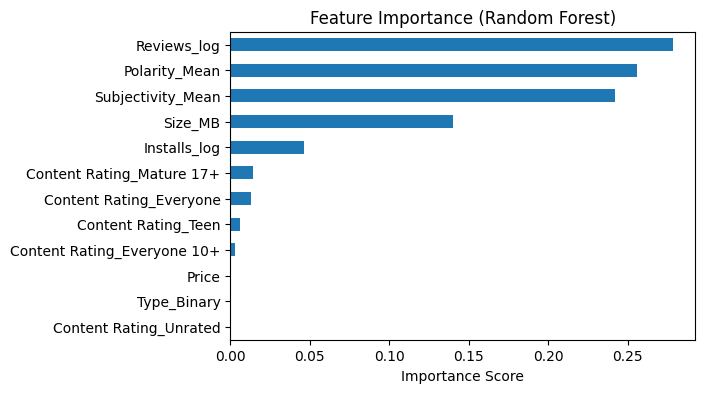

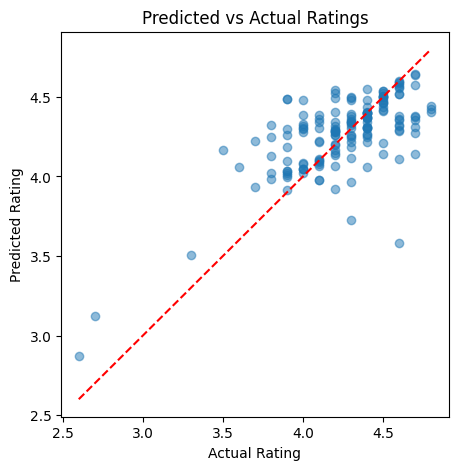

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sentiment Distribution
plt.figure(figsize=(6,4))
sns.histplot(data=df_model, x='Polarity_Mean', bins=30, kde=True)
plt.title('Distribution of Average Review Polarity')
plt.xlabel('Polarity Mean')
plt.ylabel('Frequency')
plt.show()

# 2. Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(6,4))
importances.plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

# 3. Predicted vs Actual
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs Actual Ratings')
plt.show()